In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [3]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [4]:
covid_df  = pd.read_csv('texas_uni.csv')
covid_df = covid_df.drop('PROVINCE_STATE_NAME', axis=1)

train_size = int(len(covid_df) * 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]
covid_train = covid_train.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_test = covid_test.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

In [5]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Baseline Univariate

In [6]:
prop_base = Prophet()
prop_base.fit(covid_train)
prop_base_df = prop_base.make_future_dataframe(periods=len(covid_test))
prop_base_pred = prop_base.predict(prop_base_df)
prop_base_train = prop_base.predict(covid_train)
prop_base_test = prop_base.predict(covid_test)

21:53:06 - cmdstanpy - INFO - Chain [1] start processing
21:53:06 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

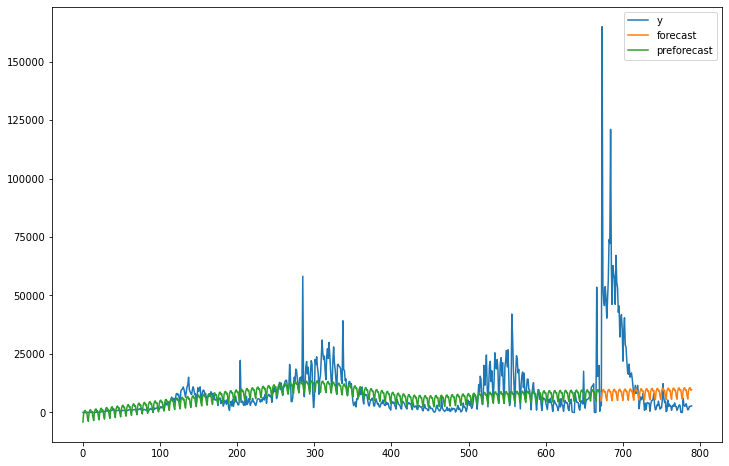

In [7]:
prophet_df_base = pd.DataFrame(covid_df)
prophet_df_base = prophet_df_base.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_base['ds'] = pd.to_datetime(prophet_df_base['ds'])

prophet_df_base['forecast'] = prop_base_test['yhat']
length1 = len(prophet_df_base) - len(prop_base_test)
forecast1 = pd.concat([pd.Series([np.nan] * length1), prop_base_test['yhat']], ignore_index=True)
prophet_df_base['forecast'] = forecast1

prophet_df_base['preforecast']=prop_base_train['yhat']

prophet_df_base[['y','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:>

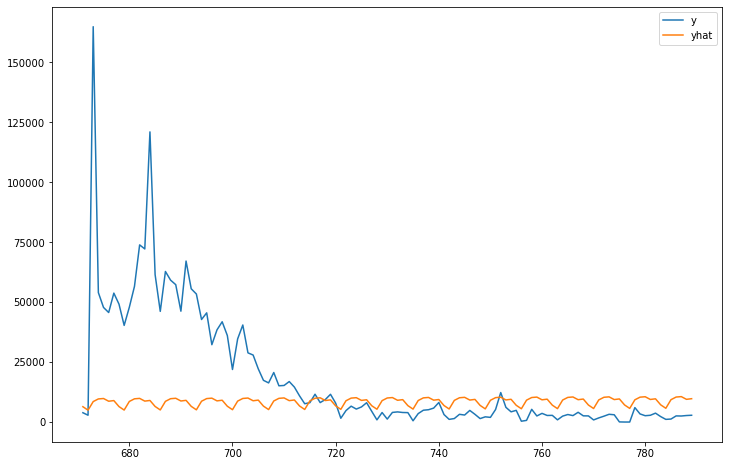

In [8]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_base_test['yhat'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

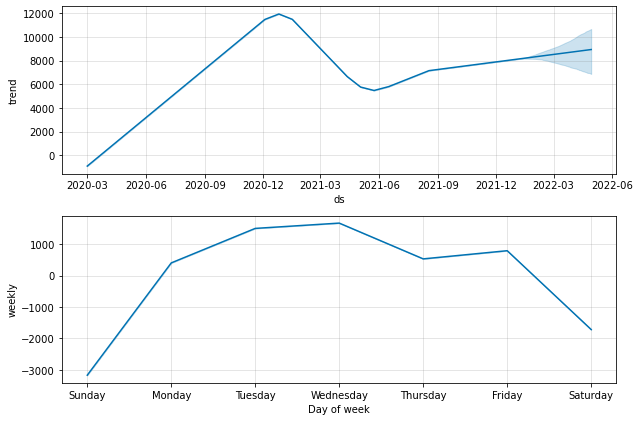

In [9]:
future_baseline = prop_base.make_future_dataframe(periods=len(covid_test))
future_baseline['ds'] = pd.to_datetime(future_baseline['ds'])
forecast_baseline = prop_base.predict(future_baseline)
prop_base.plot_components(forecast_baseline);

In [10]:
performance_baseline = pd.concat([covid_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(16)], keys=['ds'])

In [11]:
print('MAE = ', mean_absolute_error(performance_baseline['y'], performance_baseline['yhat']))
print('MASE = ', mase(performance_baseline['y'], performance_baseline['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_baseline['yhat'], performance_baseline['y'])))

MAE =  16207.539996945605
MASE =  2.4328927850374464
RMSE =  27810.163382528637


## Tuned Univariate

In [12]:
prop_base.changepoints

21    2020-03-22
43    2020-04-13
64    2020-05-04
86    2020-05-26
107   2020-06-16
128   2020-07-07
150   2020-07-29
171   2020-08-19
193   2020-09-10
214   2020-10-01
235   2020-10-22
257   2020-11-13
278   2020-12-04
300   2020-12-26
321   2021-01-16
342   2021-02-06
364   2021-02-28
385   2021-03-21
407   2021-04-12
428   2021-05-03
449   2021-05-24
471   2021-06-15
492   2021-07-06
514   2021-07-28
535   2021-08-18
Name: ds, dtype: datetime64[ns]

In [13]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window updated to 2021-22 since the 2020 one is out of our window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [14]:
prophet_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative', n_changepoints=25, holidays=events)
prophet_tuned.add_country_holidays(country_name='US')

prophet_tuned.fit(covid_train)
prop_season_train = prophet_tuned.predict(covid_train)
prop_season_test = prophet_tuned.predict(covid_test)

21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:>

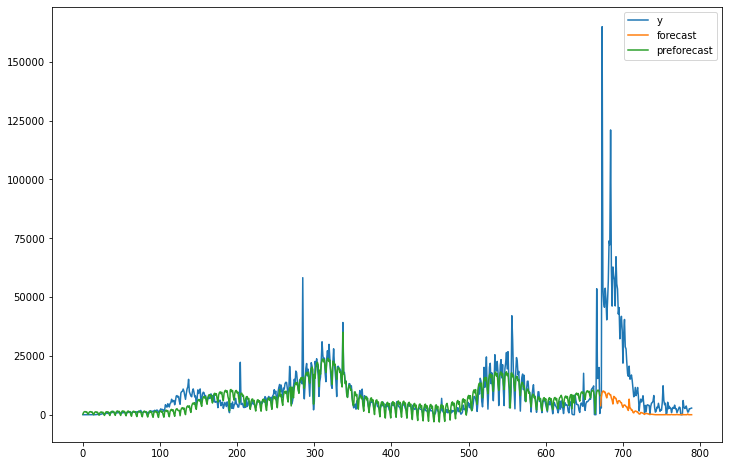

In [15]:
prophet_df_season = pd.DataFrame(covid_df)
prophet_df_season = prophet_df_season.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_season['ds'] = pd.to_datetime(prophet_df_season['ds'])

prophet_df_season['forecast'] = prop_season_test['yhat']
length2 = len(prophet_df_season) - len(prop_season_test)
forecast2 = pd.concat([pd.Series([np.nan] * length2), prop_season_test['yhat']], ignore_index=True)
prophet_df_season['forecast'] = forecast2
prophet_df_season['forecast'] = np.clip(prophet_df_season['forecast'], 0, None)


prophet_df_season['preforecast']=prop_season_train['yhat']

prophet_df_season[['y','forecast', 'preforecast']].plot(figsize=(12,8))

<AxesSubplot:>

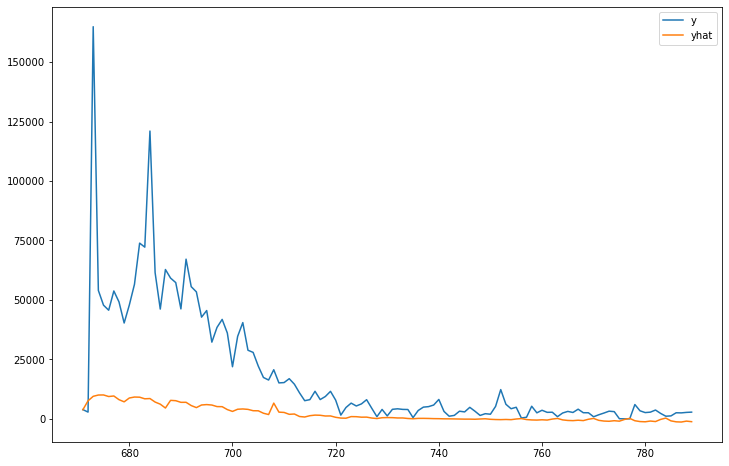

In [16]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prop_season_test['yhat'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [17]:
tuned_df = prophet_tuned.make_future_dataframe(periods=len(covid_test))
tuned_df['ds'] = pd.to_datetime(tuned_df['ds'])
forecast_tuned = prop_base.predict(tuned_df)

tunned_performance = pd.concat([covid_test, forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(119)], keys=['ds'])
print('MAE = ', mean_absolute_error(tunned_performance['y'], tunned_performance['yhat']))
print('MASE = ', mase(tunned_performance['y'], tunned_performance['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(tunned_performance['yhat'], tunned_performance['y'])))

MAE =  16296.268733557185
MASE =  2.4462117404846313
RMSE =  28361.833133399276


## Baseline Multivariate 

In [ ]:
import os
os._exit(00)

In [18]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb

from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [19]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [20]:
covid_df = pd.read_csv('texas_multi_df.csv', parse_dates=['Date'])
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})

train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [21]:
covid_train = covid_train[['ds', 'y', 'new_deaths_2_lag', 'new_deaths_50_lag', 'new_cases_2_lag', 'dew_point', 'relative_humidity', 'new_cases_150_lag', 'current_intensive_care_patients', 'new_deaths_3_lag', 'new_cases_3_lag', 'new_deaths_100_std', 'new_deaths_4_lag', 'average_temperature_celsius', 'new_deaths_30_lag', 'new_cases_10_min', 'new_cases_7_lag', 'new_cases_4_lag', 'new_deaths_1_lag', 'new_cases_50_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_7_lag', 'new_cases_10_mean', 'new_hospitalized_patients', 'new_cases_10_max', 'new_cases_1 lag']]
covid_test = covid_test[['ds', 'y', 'new_deaths_2_lag', 'new_deaths_50_lag', 'new_cases_2_lag', 'dew_point', 'relative_humidity', 'new_cases_150_lag', 'current_intensive_care_patients', 'new_deaths_3_lag', 'new_cases_3_lag', 'new_deaths_100_std', 'new_deaths_4_lag', 'average_temperature_celsius', 'new_deaths_30_lag', 'new_cases_10_min', 'new_cases_7_lag', 'new_cases_4_lag', 'new_deaths_1_lag', 'new_cases_50_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_7_lag', 'new_cases_10_mean', 'new_hospitalized_patients', 'new_cases_10_max', 'new_cases_1 lag']]

In [22]:
multi_prop = Prophet(yearly_seasonality=True, weekly_seasonality=True)

regressors = ['new_deaths_2_lag', 'new_deaths_50_lag', 'new_cases_2_lag', 'dew_point', 'relative_humidity', 'new_cases_150_lag', 'current_intensive_care_patients', 'new_deaths_3_lag', 'new_cases_3_lag', 'new_deaths_100_std', 'new_deaths_4_lag', 'average_temperature_celsius', 'new_deaths_30_lag', 'new_cases_10_min', 'new_cases_7_lag', 'new_cases_4_lag', 'new_deaths_1_lag', 'new_cases_50_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_7_lag', 'new_cases_10_mean', 'new_hospitalized_patients', 'new_cases_10_max', 'new_cases_1 lag']
for regressor in regressors:
    multi_prop.add_regressor(regressor, standardize=False)
    
multi_prop.fit(covid_train)

21:53:26 - cmdstanpy - INFO - Chain [1] start processing
21:53:27 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future_multi = multi_prop.make_future_dataframe(periods=len(covid_test))
future_multi = pd.merge(future_multi, covid_df[['ds', 'vaccination_rate_1dose', 'new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_50_max', 'new_cases_4_lag', 'new_cases_50_min', 'new_deaths_10_min', 'new_deaths_50_max', 'new_cases_50_std', 'Booster_Doses_65Plus', 'maximum_temperature_celsius', 'new_cases_50_mean', 'dew_point', 'new_deaths_100_mean', 'new_deaths_4_lag', 'new_cases_350_lag', 'new_deaths_7_lag', 'new_deaths_50_lag', 'new_deaths_50_min', 'new_deaths_30_lag', 'Administered_Dose1_Recip_5Plus', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'minimum_temperature_celsius', 'new_cases_150_lag', 'new_deaths_50_std', 'new_deaths_10_max', 'new_cases_50_lag', 'new_cases_1 lag', 'Booster_Doses_18Plus', 'average_temperature_celsius', 'Series_Complete_65Plus', 'new_deaths_100_std', 'Completeness_pct', 'new_cases_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_10_std', 'new_deaths_3_lag', 'vaccination_rate_complete', 'Series_Complete_5Plus', 'vaccination_policy', 'new_cases_10_mean', 'new_deaths_100_max', 'new_cases_10_min', 'booster_rate', 'new_cases_7_lag', 'new_deaths_2_lag', 'new_cases_100_min', 'new_deaths_100_min', 'new_cases_100_max', 'rainfall_mm', 'new_cases_100_mean', 'current_intensive_care_patients', 'restrictions_on_gatherings', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'Administered_Dose1_Recip', 'stringency_index', 'facial_coverings', 'new_deaths_1_lag']], on='ds', how='inner')
forecast_multi = multi_prop.predict(future_multi)
forecast_multi['yhat'] = np.clip(forecast_multi['yhat'], 0, None)


In [24]:
covid_test

,ds,y,new_deaths_2_lag,new_deaths_50_lag,new_cases_2_lag,dew_point,relative_humidity,new_cases_150_lag,current_intensive_care_patients,new_deaths_3_lag,...,new_cases_4_lag,new_deaths_1_lag,new_cases_50_std,new_cases_10_std,PEOPLE_DEATH_NEW_COUNT,new_deaths_7_lag,new_cases_10_mean,new_hospitalized_patients,new_cases_10_max,new_cases_1 lag
671,2022-01-01,3882,106.0,270.0,20069.0,7.290123,47.748570,11649.0,1425.0,78.0,...,15411.0,1.0,8303.850037,16480.328827,0,0.0,12123.7,1414.0,53547.0,505.0
672,2022-01-02,2843,1.0,68.0,505.0,-9.037037,44.876698,17534.0,1483.0,106.0,...,15536.0,0.0,8303.574359,16738.782923,0,0.0,11183.2,1308.0,53547.0,3882.0
673,2022-01-03,164902,0.0,28.0,3882.0,-12.259259,37.218602,24559.0,1569.0,1.0,...,20069.0,0.0,23911.431586,50890.925939,218,161.0,27669.5,1352.0,164902.0,2843.0
674,2022-01-04,53990,0.0,50.0,2843.0,-10.191358,27.477799,11265.0,1642.0,0.0,...,505.0,218.0,24708.837780,50491.641296,67,81.0,33068.5,1670.0,164902.0,164902.0
675,2022-01-05,47796,218.0,75.0,164902.0,-5.771605,33.212225,2372.0,1759.0,0.0,...,3882.0,67.0,25252.731328,49260.735287,99,78.0,37848.1,1821.0,164902.0,53990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1243,7.0,42.0,2276.0,13.000000,71.796888,40.0,164.0,55.0,...,2817.0,4.0,2200.629620,1840.177467,4,44.0,2319.0,99.0,6020.0,1110.0
786,2022-04-26,2556,4.0,43.0,1110.0,7.740741,58.059698,37.0,156.0,7.0,...,3708.0,4.0,2201.413286,1649.962033,20,49.0,2574.6,120.0,6020.0,1243.0
787,2022-04-27,2513,4.0,113.0,1243.0,13.314815,70.772471,-6.0,163.0,4.0,...,2276.0,20.0,2187.241125,1384.240060,16,42.0,2825.9,126.0,6020.0,2556.0
788,2022-04-28,2715,20.0,126.0,2556.0,15.706349,64.021362,8455.0,149.0,4.0,...,1110.0,16.0,2167.189568,813.961943,24,23.0,2495.4,115.0,3708.0,2513.0


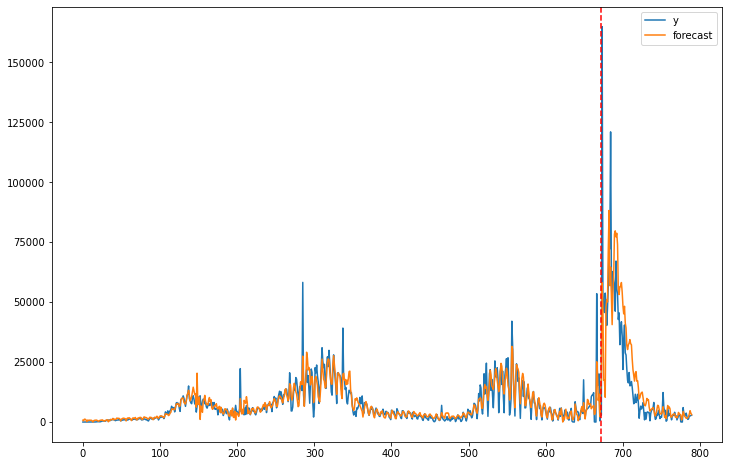

In [25]:
prophet_df_multi = pd.DataFrame(covid_df)
prophet_df_multi = prophet_df_multi.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi['ds'] = pd.to_datetime(prophet_df_multi['ds'])

prophet_df_multi['forecast']=forecast_multi['yhat']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

In [26]:
covid_test

,ds,y,new_deaths_2_lag,new_deaths_50_lag,new_cases_2_lag,dew_point,relative_humidity,new_cases_150_lag,current_intensive_care_patients,new_deaths_3_lag,...,new_cases_4_lag,new_deaths_1_lag,new_cases_50_std,new_cases_10_std,PEOPLE_DEATH_NEW_COUNT,new_deaths_7_lag,new_cases_10_mean,new_hospitalized_patients,new_cases_10_max,new_cases_1 lag
671,2022-01-01,3882,106.0,270.0,20069.0,7.290123,47.748570,11649.0,1425.0,78.0,...,15411.0,1.0,8303.850037,16480.328827,0,0.0,12123.7,1414.0,53547.0,505.0
672,2022-01-02,2843,1.0,68.0,505.0,-9.037037,44.876698,17534.0,1483.0,106.0,...,15536.0,0.0,8303.574359,16738.782923,0,0.0,11183.2,1308.0,53547.0,3882.0
673,2022-01-03,164902,0.0,28.0,3882.0,-12.259259,37.218602,24559.0,1569.0,1.0,...,20069.0,0.0,23911.431586,50890.925939,218,161.0,27669.5,1352.0,164902.0,2843.0
674,2022-01-04,53990,0.0,50.0,2843.0,-10.191358,27.477799,11265.0,1642.0,0.0,...,505.0,218.0,24708.837780,50491.641296,67,81.0,33068.5,1670.0,164902.0,164902.0
675,2022-01-05,47796,218.0,75.0,164902.0,-5.771605,33.212225,2372.0,1759.0,0.0,...,3882.0,67.0,25252.731328,49260.735287,99,78.0,37848.1,1821.0,164902.0,53990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1243,7.0,42.0,2276.0,13.000000,71.796888,40.0,164.0,55.0,...,2817.0,4.0,2200.629620,1840.177467,4,44.0,2319.0,99.0,6020.0,1110.0
786,2022-04-26,2556,4.0,43.0,1110.0,7.740741,58.059698,37.0,156.0,7.0,...,3708.0,4.0,2201.413286,1649.962033,20,49.0,2574.6,120.0,6020.0,1243.0
787,2022-04-27,2513,4.0,113.0,1243.0,13.314815,70.772471,-6.0,163.0,4.0,...,2276.0,20.0,2187.241125,1384.240060,16,42.0,2825.9,126.0,6020.0,2556.0
788,2022-04-28,2715,20.0,126.0,2556.0,15.706349,64.021362,8455.0,149.0,4.0,...,1110.0,16.0,2167.189568,813.961943,24,23.0,2495.4,115.0,3708.0,2513.0


In [27]:
graph_df = pd.DataFrame(covid_test['y'])
#graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_deaths_2_lag,new_deaths_50_lag,new_cases_2_lag,dew_point,relative_humidity,new_cases_150_lag,current_intensive_care_patients,new_deaths_3_lag,...,new_cases_4_lag,new_deaths_1_lag,new_cases_50_std,new_cases_10_std,PEOPLE_DEATH_NEW_COUNT,new_deaths_7_lag,new_cases_10_mean,new_hospitalized_patients,new_cases_10_max,new_cases_1 lag
671,2022-01-01,3882,106.0,270.0,20069.0,7.290123,47.748570,11649.0,1425.0,78.0,...,15411.0,1.0,8303.850037,16480.328827,0,0.0,12123.7,1414.0,53547.0,505.0
672,2022-01-02,2843,1.0,68.0,505.0,-9.037037,44.876698,17534.0,1483.0,106.0,...,15536.0,0.0,8303.574359,16738.782923,0,0.0,11183.2,1308.0,53547.0,3882.0
673,2022-01-03,164902,0.0,28.0,3882.0,-12.259259,37.218602,24559.0,1569.0,1.0,...,20069.0,0.0,23911.431586,50890.925939,218,161.0,27669.5,1352.0,164902.0,2843.0
674,2022-01-04,53990,0.0,50.0,2843.0,-10.191358,27.477799,11265.0,1642.0,0.0,...,505.0,218.0,24708.837780,50491.641296,67,81.0,33068.5,1670.0,164902.0,164902.0
675,2022-01-05,47796,218.0,75.0,164902.0,-5.771605,33.212225,2372.0,1759.0,0.0,...,3882.0,67.0,25252.731328,49260.735287,99,78.0,37848.1,1821.0,164902.0,53990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1243,7.0,42.0,2276.0,13.000000,71.796888,40.0,164.0,55.0,...,2817.0,4.0,2200.629620,1840.177467,4,44.0,2319.0,99.0,6020.0,1110.0
786,2022-04-26,2556,4.0,43.0,1110.0,7.740741,58.059698,37.0,156.0,7.0,...,3708.0,4.0,2201.413286,1649.962033,20,49.0,2574.6,120.0,6020.0,1243.0
787,2022-04-27,2513,4.0,113.0,1243.0,13.314815,70.772471,-6.0,163.0,4.0,...,2276.0,20.0,2187.241125,1384.240060,16,42.0,2825.9,126.0,6020.0,2556.0
788,2022-04-28,2715,20.0,126.0,2556.0,15.706349,64.021362,8455.0,149.0,4.0,...,1110.0,16.0,2167.189568,813.961943,24,23.0,2495.4,115.0,3708.0,2513.0


In [28]:
graph_df['yhat'] = forecast_multi['yhat'].tail(119).values
#graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

,ds,y,new_deaths_2_lag,new_deaths_50_lag,new_cases_2_lag,dew_point,relative_humidity,new_cases_150_lag,current_intensive_care_patients,new_deaths_3_lag,...,new_cases_4_lag,new_deaths_1_lag,new_cases_50_std,new_cases_10_std,PEOPLE_DEATH_NEW_COUNT,new_deaths_7_lag,new_cases_10_mean,new_hospitalized_patients,new_cases_10_max,new_cases_1 lag
671,2022-01-01,3882,106.0,270.0,20069.0,7.290123,47.748570,11649.0,1425.0,78.0,...,15411.0,1.0,8303.850037,16480.328827,0,0.0,12123.7,1414.0,53547.0,505.0
672,2022-01-02,2843,1.0,68.0,505.0,-9.037037,44.876698,17534.0,1483.0,106.0,...,15536.0,0.0,8303.574359,16738.782923,0,0.0,11183.2,1308.0,53547.0,3882.0
673,2022-01-03,164902,0.0,28.0,3882.0,-12.259259,37.218602,24559.0,1569.0,1.0,...,20069.0,0.0,23911.431586,50890.925939,218,161.0,27669.5,1352.0,164902.0,2843.0
674,2022-01-04,53990,0.0,50.0,2843.0,-10.191358,27.477799,11265.0,1642.0,0.0,...,505.0,218.0,24708.837780,50491.641296,67,81.0,33068.5,1670.0,164902.0,164902.0
675,2022-01-05,47796,218.0,75.0,164902.0,-5.771605,33.212225,2372.0,1759.0,0.0,...,3882.0,67.0,25252.731328,49260.735287,99,78.0,37848.1,1821.0,164902.0,53990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1243,7.0,42.0,2276.0,13.000000,71.796888,40.0,164.0,55.0,...,2817.0,4.0,2200.629620,1840.177467,4,44.0,2319.0,99.0,6020.0,1110.0
786,2022-04-26,2556,4.0,43.0,1110.0,7.740741,58.059698,37.0,156.0,7.0,...,3708.0,4.0,2201.413286,1649.962033,20,49.0,2574.6,120.0,6020.0,1243.0
787,2022-04-27,2513,4.0,113.0,1243.0,13.314815,70.772471,-6.0,163.0,4.0,...,2276.0,20.0,2187.241125,1384.240060,16,42.0,2825.9,126.0,6020.0,2556.0
788,2022-04-28,2715,20.0,126.0,2556.0,15.706349,64.021362,8455.0,149.0,4.0,...,1110.0,16.0,2167.189568,813.961943,24,23.0,2495.4,115.0,3708.0,2513.0


,ds,y,new_deaths_2_lag,new_deaths_50_lag,new_cases_2_lag,dew_point,relative_humidity,new_cases_150_lag,current_intensive_care_patients,new_deaths_3_lag,...,new_cases_4_lag,new_deaths_1_lag,new_cases_50_std,new_cases_10_std,PEOPLE_DEATH_NEW_COUNT,new_deaths_7_lag,new_cases_10_mean,new_hospitalized_patients,new_cases_10_max,new_cases_1 lag
671,2022-01-01,3882,106.0,270.0,20069.0,7.290123,47.748570,11649.0,1425.0,78.0,...,15411.0,1.0,8303.850037,16480.328827,0,0.0,12123.7,1414.0,53547.0,505.0
672,2022-01-02,2843,1.0,68.0,505.0,-9.037037,44.876698,17534.0,1483.0,106.0,...,15536.0,0.0,8303.574359,16738.782923,0,0.0,11183.2,1308.0,53547.0,3882.0
673,2022-01-03,164902,0.0,28.0,3882.0,-12.259259,37.218602,24559.0,1569.0,1.0,...,20069.0,0.0,23911.431586,50890.925939,218,161.0,27669.5,1352.0,164902.0,2843.0
674,2022-01-04,53990,0.0,50.0,2843.0,-10.191358,27.477799,11265.0,1642.0,0.0,...,505.0,218.0,24708.837780,50491.641296,67,81.0,33068.5,1670.0,164902.0,164902.0
675,2022-01-05,47796,218.0,75.0,164902.0,-5.771605,33.212225,2372.0,1759.0,0.0,...,3882.0,67.0,25252.731328,49260.735287,99,78.0,37848.1,1821.0,164902.0,53990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1243,7.0,42.0,2276.0,13.000000,71.796888,40.0,164.0,55.0,...,2817.0,4.0,2200.629620,1840.177467,4,44.0,2319.0,99.0,6020.0,1110.0
786,2022-04-26,2556,4.0,43.0,1110.0,7.740741,58.059698,37.0,156.0,7.0,...,3708.0,4.0,2201.413286,1649.962033,20,49.0,2574.6,120.0,6020.0,1243.0
787,2022-04-27,2513,4.0,113.0,1243.0,13.314815,70.772471,-6.0,163.0,4.0,...,2276.0,20.0,2187.241125,1384.240060,16,42.0,2825.9,126.0,6020.0,2556.0
788,2022-04-28,2715,20.0,126.0,2556.0,15.706349,64.021362,8455.0,149.0,4.0,...,1110.0,16.0,2167.189568,813.961943,24,23.0,2495.4,115.0,3708.0,2513.0


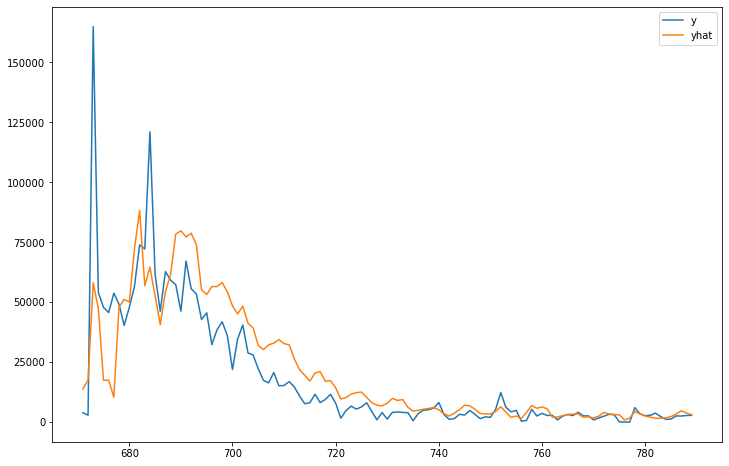

In [29]:
graph_df[['y','yhat']].plot(figsize=(12,8))
covid_test

In [30]:
covid_test

,ds,y,new_deaths_2_lag,new_deaths_50_lag,new_cases_2_lag,dew_point,relative_humidity,new_cases_150_lag,current_intensive_care_patients,new_deaths_3_lag,...,new_cases_4_lag,new_deaths_1_lag,new_cases_50_std,new_cases_10_std,PEOPLE_DEATH_NEW_COUNT,new_deaths_7_lag,new_cases_10_mean,new_hospitalized_patients,new_cases_10_max,new_cases_1 lag
671,2022-01-01,3882,106.0,270.0,20069.0,7.290123,47.748570,11649.0,1425.0,78.0,...,15411.0,1.0,8303.850037,16480.328827,0,0.0,12123.7,1414.0,53547.0,505.0
672,2022-01-02,2843,1.0,68.0,505.0,-9.037037,44.876698,17534.0,1483.0,106.0,...,15536.0,0.0,8303.574359,16738.782923,0,0.0,11183.2,1308.0,53547.0,3882.0
673,2022-01-03,164902,0.0,28.0,3882.0,-12.259259,37.218602,24559.0,1569.0,1.0,...,20069.0,0.0,23911.431586,50890.925939,218,161.0,27669.5,1352.0,164902.0,2843.0
674,2022-01-04,53990,0.0,50.0,2843.0,-10.191358,27.477799,11265.0,1642.0,0.0,...,505.0,218.0,24708.837780,50491.641296,67,81.0,33068.5,1670.0,164902.0,164902.0
675,2022-01-05,47796,218.0,75.0,164902.0,-5.771605,33.212225,2372.0,1759.0,0.0,...,3882.0,67.0,25252.731328,49260.735287,99,78.0,37848.1,1821.0,164902.0,53990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1243,7.0,42.0,2276.0,13.000000,71.796888,40.0,164.0,55.0,...,2817.0,4.0,2200.629620,1840.177467,4,44.0,2319.0,99.0,6020.0,1110.0
786,2022-04-26,2556,4.0,43.0,1110.0,7.740741,58.059698,37.0,156.0,7.0,...,3708.0,4.0,2201.413286,1649.962033,20,49.0,2574.6,120.0,6020.0,1243.0
787,2022-04-27,2513,4.0,113.0,1243.0,13.314815,70.772471,-6.0,163.0,4.0,...,2276.0,20.0,2187.241125,1384.240060,16,42.0,2825.9,126.0,6020.0,2556.0
788,2022-04-28,2715,20.0,126.0,2556.0,15.706349,64.021362,8455.0,149.0,4.0,...,1110.0,16.0,2167.189568,813.961943,24,23.0,2495.4,115.0,3708.0,2513.0


In [31]:
performance_multi = pd.merge(covid_test, forecast_multi[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE = ', mean_absolute_error(performance_multi['y'], performance_multi['yhat']))
print('MASE = ', mase(performance_multi['y'], performance_multi['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE =  8364.400761810955
MASE =  1.2555693379998807
RMSE =  15363.79930211363


## Tuned Multivariate

In [32]:
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(covid_train)  # Fit model with given params
    df_cv = cross_validation(m, initial='200 days', period='20 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:53:31 - cmdstanpy - INFO - Chain [1] start processing
21:53:31 - cmdstanpy - INFO - Chain [1] done processing
21:53:39 - cmdstanpy - INFO - Chain [1] start processing
21:53:39 - cmdstanpy - INFO - Chain [1] done processing
21:53:47 - cmdstanpy - INFO - Chain [1] start processing
21:53:47 - cmdstanpy - INFO - Chain [1] done processing
21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing


KeyboardInterrupt: 

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

In [33]:
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window updated to 2021-22 since the 2020 one is out of our window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07', '2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


In [34]:
model_holiday_tuned = Prophet(yearly_seasonality=True, weekly_seasonality=True, n_changepoints=4, seasonality_prior_scale=10.0)
model_holiday_tuned.add_country_holidays(country_name='US')

regressors = ['new_deaths_2_lag', 'new_deaths_50_lag', 'new_cases_2_lag', 'dew_point', 'relative_humidity', 'new_cases_150_lag', 'current_intensive_care_patients', 'new_deaths_3_lag', 'new_cases_3_lag', 'new_deaths_100_std', 'new_deaths_4_lag', 'average_temperature_celsius', 'new_deaths_30_lag', 'new_cases_10_min', 'new_cases_7_lag', 'new_cases_4_lag', 'new_deaths_1_lag', 'new_cases_50_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_7_lag', 'new_cases_10_mean', 'new_hospitalized_patients', 'new_cases_10_max', 'new_cases_1 lag']
for regressor in regressors:
    model_holiday_tuned.add_regressor(regressor, standardize=False)

model_holiday_tuned.fit(covid_train)

21:54:24 - cmdstanpy - INFO - Chain [1] start processing
21:54:25 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future_holiday_tuned = model_holiday_tuned.make_future_dataframe(periods=len(covid_test))

future_holiday_tuned = pd.merge(future_holiday_tuned, covid_df[['ds', 'vaccination_rate_1dose', 'new_hospitalized_patients', 'new_cases_2_lag', 'new_cases_50_max', 'new_cases_4_lag', 'new_cases_50_min', 'new_deaths_10_min', 'new_deaths_50_max', 'new_cases_50_std', 'Booster_Doses_65Plus', 'maximum_temperature_celsius', 'new_cases_50_mean', 'dew_point', 'new_deaths_100_mean', 'new_deaths_4_lag', 'new_cases_350_lag', 'new_deaths_7_lag', 'new_deaths_50_lag', 'new_deaths_50_min', 'new_deaths_30_lag', 'Administered_Dose1_Recip_5Plus', 'new_deaths_50_mean', 'new_cases_10_max', 'new_cases_3_lag', 'minimum_temperature_celsius', 'new_cases_150_lag', 'new_deaths_50_std', 'new_deaths_10_max', 'new_cases_50_lag', 'new_cases_1 lag', 'Booster_Doses_18Plus', 'average_temperature_celsius', 'Series_Complete_65Plus', 'new_deaths_100_std', 'Completeness_pct', 'new_cases_100_std', 'new_cases_10_std', 'PEOPLE_DEATH_NEW_COUNT', 'new_deaths_10_std', 'new_deaths_3_lag', 'vaccination_rate_complete', 'Series_Complete_5Plus', 'vaccination_policy', 'new_cases_10_mean', 'new_deaths_100_max', 'new_cases_10_min', 'booster_rate', 'new_cases_7_lag', 'new_deaths_2_lag', 'new_cases_100_min', 'new_deaths_100_min', 'new_cases_100_max', 'rainfall_mm', 'new_cases_100_mean', 'current_intensive_care_patients', 'restrictions_on_gatherings', 'new_cases_30_lag', 'new_deaths_10_mean', 'relative_humidity', 'Administered_Dose1_Recip', 'stringency_index', 'facial_coverings', 'new_deaths_1_lag']], on='ds', how='inner')
future_holiday_tuned = future_holiday_tuned.fillna(method='ffill')

forecast_holiday_tuned = model_holiday_tuned.predict(future_holiday_tuned)
forecast_holiday_tuned['yhat'] = np.clip(forecast_holiday_tuned['yhat'], 0, None)

forecast_holiday_tuned

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,1.358046,-43959.319808,41638.011708,1.358046,1.358046,0.0,0.0,0.0,0.0,...,-352.775737,-352.775737,-352.775737,26.760038,26.760038,26.760038,0.0,0.0,0.0,51.888545
1,2020-03-02,2.090559,-39856.995585,45704.260966,2.090559,2.090559,0.0,0.0,0.0,0.0,...,174.374189,174.374189,174.374189,36.842060,36.842060,36.842060,0.0,0.0,0.0,234.110013
2,2020-03-03,2.823072,-38727.693680,44447.106316,2.823072,2.823072,0.0,0.0,0.0,0.0,...,81.510945,81.510945,81.510945,44.923012,44.923012,44.923012,0.0,0.0,0.0,840.453840
3,2020-03-04,3.555585,-41293.576031,43913.824662,3.555585,3.555585,0.0,0.0,0.0,0.0,...,-77.914111,-77.914111,-77.914111,50.983296,50.983296,50.983296,0.0,0.0,0.0,776.974286
4,2020-03-05,4.288098,-44740.259739,42590.139996,4.288098,4.288098,0.0,0.0,0.0,0.0,...,-171.156628,-171.156628,-171.156628,55.037096,55.037096,55.037096,0.0,0.0,0.0,431.481113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2022-04-25,1433.298495,-42040.963673,45399.177788,1394.335852,1480.122539,0.0,0.0,0.0,0.0,...,174.374189,174.374189,174.374189,-19.587715,-19.587715,-19.587715,0.0,0.0,0.0,2874.267701
786,2022-04-26,1435.224992,-40727.685394,49067.582067,1394.934959,1482.990566,0.0,0.0,0.0,0.0,...,81.510945,81.510945,81.510945,-34.533933,-34.533933,-34.533933,0.0,0.0,0.0,4129.911411
787,2022-04-27,1437.151489,-36002.470961,49217.911659,1396.304648,1485.780681,0.0,0.0,0.0,0.0,...,-77.914111,-77.914111,-77.914111,-48.835648,-48.835648,-48.835648,0.0,0.0,0.0,5301.586526
788,2022-04-28,1439.077986,-38375.331861,45371.488322,1397.770390,1488.564398,0.0,0.0,0.0,0.0,...,-171.156628,-171.156628,-171.156628,-62.220250,-62.220250,-62.220250,0.0,0.0,0.0,4007.442800


In [36]:
performance_holiday_tuned = pd.merge(covid_test, forecast_holiday_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-119:], on='ds')
print('MAE =', mean_absolute_error(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('MASE = ', mase(performance_holiday_tuned['y'], performance_holiday_tuned['yhat']))
print('RMSE = ', np.sqrt(mean_squared_error(performance_multi['yhat'], performance_multi['y'])))

MAE = 8514.766702852598
MASE =  1.2781405741741882
RMSE =  15363.79930211363


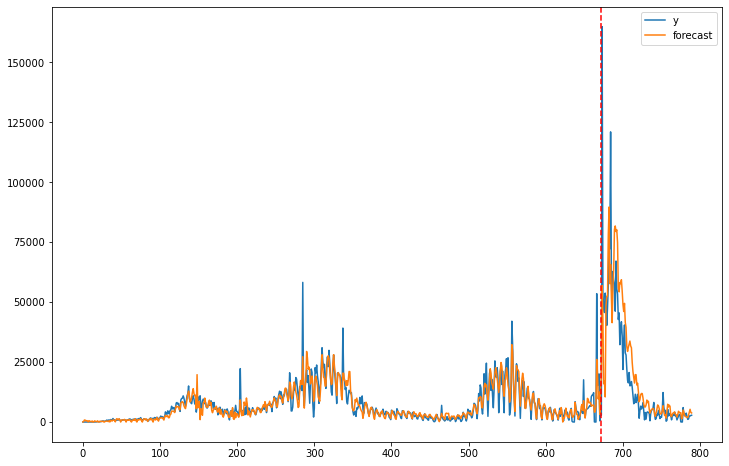

In [37]:
prophet_df_multi_tuned = pd.DataFrame(covid_df)
prophet_df_multi_tuned = prophet_df_multi_tuned.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
prophet_df_multi_tuned['ds'] = pd.to_datetime(prophet_df_multi_tuned['ds'])

prophet_df_multi_tuned['forecast']=forecast_holiday_tuned['yhat']

prophet_df_multi_tuned[['y', 'forecast']].plot(figsize=(12,8))

plt.axvline(x=672, color='red', linestyle='--', label='Split Point')
plt.show()

<AxesSubplot:>

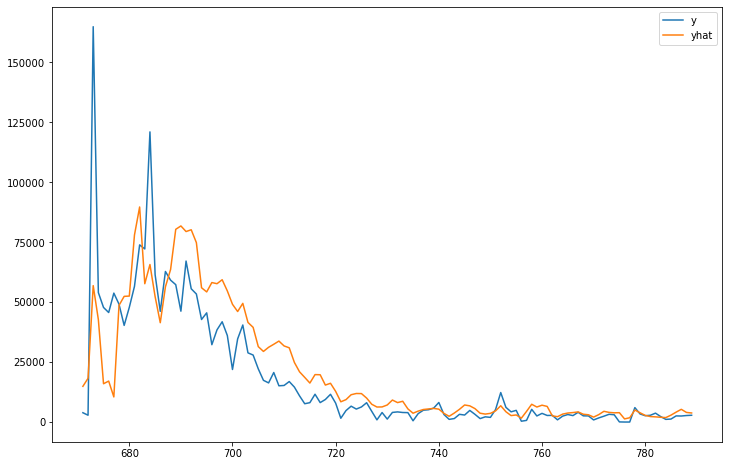

In [38]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = prophet_df_multi_tuned['forecast'].tail(119).values
graph_df[['y','yhat']].plot(figsize=(12,8))